In [38]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as random
from scipy.signal import convolve
import scipy
from joblib import Parallel, delayed

%run initMethods.py
%run makeGif.py
%run methods.py

In [56]:
params = { #parameters relevant for the equations
    "Nh":            1000,
    "N0":             200,
    "R0":              20,
    "M":                1, #Also L, total number of spacers
    "D":                3, #Unused
    "mu":             0.1, #mutation rate
    "gamma_shape":     20, 
    "Np":               0, #Number of Cas Protein
    "dc":               3, #Required number of complexes to activate defence
    "h":                4, #coordination coeff
    "r":              100, #cross-reactivity kernel
    "rho":           5e-5, #spacer sharing coeff
}
sim_params = { #parameters relevant for the simulation (including Inital Valuess)
    "xdomain":                  100,
    "dx":                         1,
    "t0":                         0, 
    "tf":                       100,
    "dt":                         1,
    "initial_mean":           [0,0],
    "initial_var":                5,
    "n_step_prior":               5,
    "conv_size":                100,
}

In [58]:
n = init_guassian(params["N0"], sim_params)
nh = init_guassian(params["Nh"], sim_params)
kernel = init_kernel(params, sim_params)

In [65]:
def fitness_related_calc(n_split, nh_split, params, sim_params):
    p_slipt = coverage_convolve(nh, kernel, params, sim_params)
    f_split = fitness_spacers(n, nh, params, sim_params)
    n_split = virus_growth(n, f, params, sim_params)
 ``
    nh_split = immunity_gain(nh, n, params, sim_params)
    nh_split = immunity_loss(nh, n, params, sim_params)
    return n_split, nh_split

In [54]:
# for i in range(5):
f = fitness_spacers_controlled(n, nh, params, sim_params) #f is now a masked array (where mask is where eff_R0 = 0)
n = virus_growth(n, f, params, sim_params) #update
n = mutation(n, params, sim_params)

nh = immunity_gain(nh, n) #update nh
nh = immunity_loss(nh, n)

In [61]:
# f = fitness_spacers_controlled(n, nh, params, sim_params)
kernel = init_kernel(params, sim_params)
input_data = nh

In [62]:
kernel.shape

(200, 200)

In [72]:
from joblib import Parallel, delayed

num_cores = 32

def convolve_subset(input_data_subset):
    return scipy.signal.convolve2d(input_data_subset, kernel, mode='same'), 'test'

input_data_subsets = np.array_split(input_data, num_cores, axis = 0)

results = Parallel(n_jobs=num_cores)(delayed(convolve_subset)(subset) for subset in input_data_subsets)

output_data = np.concatenate(results[:][0], axis = 0)

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 0 dimension(s)

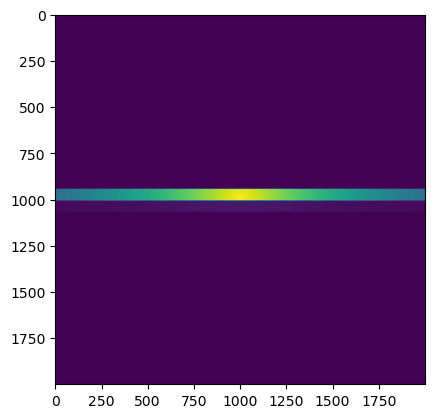

In [50]:
plt.imshow(output_data)

In [59]:
from joblib import Parallel, delayed

num_cores = 16

def convolve_subset(input_data_subset):
    return scipy.signal.convolve2d(input_data_subset, kernel, mode='same')

input_data_subsets = np.array_split(input_data, num_cores, axis = 0)

results = Parallel(n_jobs=num_cores)(delayed(convolve_subset)(subset) for subset in input_data_subsets)

output_data = np.concatenate(results, axis = 0)

KeyboardInterrupt: 

In [51]:
def update_by_section(n, nh, params, sim_params):
    

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])